## advice from krish:
- Forward selection after interaction terms
- Use bins as predictors - not quadratic 

- Conceptual: Slide 5: Visualization must be before stepwise selection. A variable requiring transformation / binning to significantly explain the response may get dropped in stepwise. Stepwise selection should be done after considering interactions. 
- Slide 9: Plug-in the bins of TrainingTimesLastYear as predictors. For DistanceFromHome, it seems like no binning / transformation is needed as it almost has a monotonic relationship with the response. For the report; If not already, obtain the final model using some variable selection approach - maybe some predictor will drop - making it easier to infer, without compromising prediction accuracy. As you have enough predictors, try to come up with at least some non-intuitive recommendations, and quantify the impact of recommendations

1. VIF
2. Transformations - ask TA these... 
       a. what transformations do we perform? Do we need to bin anything before forward selection?
       b. can you do transformations on binned vars?
       c. can you do forward selection on binned vars?
       d. do we do VIF before transformations? 
       e. how to stop interaction function from intracting w dummy variables of same type
       f. how do add specific transfomraitons to our forward selectoin

3. Forward selection - with interactions and transformations

- add transformations as a column in the training data
- visualize transformations with bins and then perform transformations on original variable
- could try ordinal "bins"
- might

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import statsmodels.formula.api as sm
import warnings 
import itertools

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc

In [2]:
# run this if imlearn not installed
# !pip install imblearn

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,5

In [4]:
warnings.filterwarnings('ignore')

In [5]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

# Description of Variables

- Age: The age of the employee. (Numerical)
- Attrition: Whether or not the employee has left the organization. (Categorical)
- BusinessTravel: The frequency of business travel for the employee. (Categorical)
- DailyRate: The daily rate of pay for the employee. (Numerical)
- Department: The department the employee works in. (Categorical)
- DistanceFromHome: The distance from home in miles for the employee. (Numerical)
- Education: The level of education achieved by the employee. (Categorical)
- EducationField: The field of study for the employee's education. (Categorical)
- EmployeeCount: The total number of employees in the organization. (Numerical)
- EmployeeNumber: A unique identifier for each employee profile. (Numerical)
- EnvironmentSatisfaction: The employee's satisfaction with their work environment. (Categorical)
- Gender: The gender of the employee. (Categorical)
- HourlyRate: The hourly rate of pay for the employee. (Numerical)
- JobInvolvement: The level of involvement required for the employee's job. (Categorical)
- JobLevel: The job level of the employee. (Categorical)
- JobRole: The role of the employee in the organization. (Categorical)
- JobSatisfaction: The employee's satisfaction with their job. (Categorical)
- MaritalStatus: The marital status of the employee. (Categorical)
- MonthlyIncome: The monthly income of the employee. (Numerical)
- MonthlyRate: The monthly rate of pay for the employee. (Numerical)
- NumCompaniesWorked: The number of companies the employee has worked for. (Numerical)
- Over18: Whether or not the employee is over 18. (Categorical)
- OverTime: Whether or not the employee works overtime. (Categorical)
- PercentSalaryHike: The percentage of salary hike for the employee. (Numerical)
- PerformanceRating: The performance rating of the employee. (Categorical)
- RelationshipSatisfaction: The employee's satisfaction with their relationships. (Categorical)
- StandardHours: The standard hours of work for the employee. (Numerical)
- StockOptionLevel: The stock option level of the employee. (Numerical)
- TotalWorkingYears: The total number of years the employee has worked. (Numerical)
- TrainingTimesLastYear: The number of times the employee was taken for training in the last year. (Numerical)
- WorkLifeBalance: The employee's perception of their work-life balance. (Categorical)
- YearsAtCompany: The number of years the employee has been with the company. (Numerical)
- YearsInCurrentRole: The number of years the employee has been in their current role. (Numerical)
- YearsSinceLastPromotion: The number of years since the employee's last promotion. (Numerical)
- YearsWithCurrManager: The number of years the employee has been with their current manager. (Numerical)

- make people who leave the job 1 (bc there are far less of them)
- min false neg rate to maximizew recall 
- precision recall is a good metric to optimize (most imp recall)
- minimize ppl who will leave

In [6]:
#Load data
df=pd.read_csv("data/HR_Analytics.csv")
df = pd.get_dummies(df, columns = ["Attrition"])
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_No,Attrition_Yes
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,...,0,8,0,1,6,4,0,5,0,1
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,...,1,10,3,3,10,7,1,7,1,0
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,...,0,7,3,3,0,0,0,0,0,1
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,0,8,3,3,8,7,3,0,1,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,...,1,6,3,3,2,2,2,2,1,0


In [7]:
#Keep the dummy column where employees leaving = 1, because there are far less of them and we want to minimize FNR and recall
df = df.drop(["Attrition_No"], axis = 1)

In [8]:
#Splitting up data into train and test data - train has 70% of values and test has 30%
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=25)

print(f"No. of training examples: {train.shape[0]}")
print(f"No. of testing examples: {test.shape[0]}")

No. of training examples: 1029
No. of testing examples: 441


In [9]:
#Printing the ratio of No's and Yes's to the response variable (Attrition) for train and test to make sure they are similar
print(train.Attrition_Yes.value_counts()[1]/train.Attrition_Yes.value_counts()[0])
print(test.Attrition_Yes.value_counts()[1]/test.Attrition_Yes.value_counts()[0])

0.1937354988399072
0.18867924528301888


In [10]:
#Shape of data
print(train.shape)
print(test.shape)

(1029, 35)
(441, 35)


In [11]:
#There are zero missing values that need to be filled in either data set
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


In [12]:
#All column names in dataframe
train.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition_Yes'],
      dtype='object')

In [13]:
#Finding correlations between variables and response
train.corrwith(train.Attrition_Yes).sort_values(ascending = False)

Attrition_Yes               1.000000
DistanceFromHome            0.065658
NumCompaniesWorked          0.029205
MonthlyRate                 0.001126
PerformanceRating          -0.007033
EmployeeNumber             -0.020580
PercentSalaryHike          -0.021023
TrainingTimesLastYear      -0.036240
WorkLifeBalance            -0.039167
Education                  -0.042102
HourlyRate                 -0.044921
YearsSinceLastPromotion    -0.048035
RelationshipSatisfaction   -0.061508
DailyRate                  -0.081930
JobSatisfaction            -0.098817
EnvironmentSatisfaction    -0.113397
JobInvolvement             -0.121431
StockOptionLevel           -0.145659
YearsAtCompany             -0.150960
YearsWithCurrManager       -0.153679
MonthlyIncome              -0.164937
JobLevel                   -0.169904
YearsInCurrentRole         -0.178133
Age                        -0.182642
TotalWorkingYears          -0.185703
EmployeeCount                    NaN
StandardHours                    NaN
d

In [14]:
train.Over18.value_counts()

Y    1029
Name: Over18, dtype: int64

In [15]:
#Drop employee count, over 18 and standard hours because they are the same value for every person
train = train.drop(["EmployeeCount", "StandardHours", "Over18"], axis = 1)
test = test.drop(["EmployeeCount", "StandardHours", "Over18"], axis = 1)
train.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_Yes'],
      dtype='object')

 OverTime, JobLevel, StockOptionLevel, JobInvolvement, BusinessTravel, NumCompaniesWorked, JobSatisfaction, EnvironmentSatisfaction, EducationField, WorkLifeBalance, Age, DistanceFromHome, YearsSinceLastPromotion, YearsInCurrentRole, YearsAtCompany, TotalWorkingYears, YearsWithCurrManager, Gender, and PercentSalaryHike

In [16]:
interactions = train.loc[:, ['OverTime', 'JobLevel', 'StockOptionLevel', 'JobInvolvement', 'BusinessTravel', 'NumCompaniesWorked', 'JobSatisfaction', 'EnvironmentSatisfaction', 'EducationField', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'YearsSinceLastPromotion', 'YearsInCurrentRole', 'YearsAtCompany', 'TotalWorkingYears', 'YearsWithCurrManager', 'Gender', 'PercentSalaryHike']]

In [17]:
#sns.pairplot(interactions)

In [18]:
#interaction terms: YearsAtCompany*TotalWorkingYears Age*TotalWorkingYears, Age*YearsAtCompany,

In [19]:
interactions.corr()

,JobLevel,StockOptionLevel,JobInvolvement,NumCompaniesWorked,JobSatisfaction,EnvironmentSatisfaction,WorkLifeBalance,Age,DistanceFromHome,YearsSinceLastPromotion,YearsInCurrentRole,YearsAtCompany,TotalWorkingYears,YearsWithCurrManager,PercentSalaryHike
JobLevel,1.000000,0.006959,-0.009112,0.153544,0.021031,0.006035,0.014191,0.511042,0.011966,0.309912,0.365351,0.497739,0.781987,0.336493,-0.008855
StockOptionLevel,0.006959,1.000000,0.067397,0.018944,0.000795,0.022180,0.026797,0.062264,0.048093,0.007439,0.034791,0.020755,0.011130,0.023468,0.007738
JobInvolvement,-0.009112,0.067397,1.000000,0.018458,-0.016585,-0.033744,0.003785,0.051137,0.003617,-0.005133,0.040467,0.006205,0.024000,0.048525,0.037431
NumCompaniesWorked,0.153544,0.018944,0.018458,1.000000,-0.031017,0.026698,-0.004100,0.299410,-0.051574,-0.064959,-0.095547,-0.134277,0.248273,-0.119842,-0.002508
JobSatisfaction,0.021031,0.000795,-0.016585,-0.031017,1.000000,-0.024880,-0.017535,0.031203,-0.027867,-0.001105,0.010160,0.019719,-0.004279,-0.005361,0.028391
EnvironmentSatisfaction,0.006035,0.022180,-0.033744,0.026698,-0.024880,1.000000,0.027154,0.032225,0.011353,0.005821,-0.017946,-0.013449,0.004853,-0.004627,-0.027728
WorkLifeBalance,0.014191,0.026797,0.003785,-0.004100,-0.017535,0.027154,1.000000,-0.022323,-0.022224,0.004330,0.030942,-0.000269,-0.009416,0.008794,-0.006314
Age,0.511042,0.062264,0.051137,0.299410,0.031203,0.032225,-0.022323,1.000000,-0.019316,0.188573,0.213709,0.291780,0.672094,0.195552,0.029420
DistanceFromHome,0.011966,0.048093,0.003617,-0.051574,-0.027867,0.011353,-0.022224,-0.019316,1.000000,0.019615,0.028074,0.023143,0.004865,0.032785,0.068196
YearsSinceLastPromotion,0.309912,0.007439,-0.005133,-0.064959,-0.001105,0.005821,0.004330,0.188573,0.019615,1.000000,0.569019,0.617816,0.379931,0.527536,0.005186


# Visualizations of initial thoughts on variables that could be correlated

In [98]:
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
numeric_cols

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1102,1,2,1,2,94,3,2,4,...,3,1,0,8,0,1,6,4,0,5
1,49,279,8,1,2,3,61,2,2,2,...,4,4,1,10,3,3,10,7,1,7
2,37,1373,2,2,4,4,92,2,1,3,...,3,2,0,7,3,3,0,0,0,0
3,33,1392,3,4,5,4,56,3,1,3,...,3,3,0,8,3,3,8,7,3,0
4,27,591,2,1,7,1,40,3,1,2,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,2061,3,41,4,2,4,...,3,3,1,17,3,3,5,2,0,3
1466,39,613,6,1,2062,4,42,2,3,1,...,3,1,1,9,5,3,7,7,1,7
1467,27,155,4,3,2064,2,87,4,2,2,...,4,2,1,6,0,3,6,2,0,3
1468,49,1023,2,3,2065,4,63,2,2,2,...,3,4,0,17,3,2,9,6,0,8


In [103]:
df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,...,1,0,8,0,1,6,4,0,5,1
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,Male,...,4,1,10,3,3,10,7,1,7,0
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,Male,...,2,0,7,3,3,0,0,0,0,1
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,Female,...,3,0,8,3,3,8,7,3,0,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,Male,...,4,1,6,3,3,2,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,Travel_Frequently,884,Research & Development,23,2,Medical,2061,3,Male,...,3,1,17,3,3,5,2,0,3,0
1466,39,Travel_Rarely,613,Research & Development,6,1,Medical,2062,4,Male,...,1,1,9,5,3,7,7,1,7,0
1467,27,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2064,2,Male,...,2,1,6,0,3,6,2,0,3,0
1468,49,Travel_Frequently,1023,Sales,2,3,Medical,2065,4,Male,...,4,0,17,3,2,9,6,0,8,0


In [104]:
# calculate the null count for each column
null_count = numeric_cols.isnull().sum()
null_count.name = 'count of null' 

# find the datatype for each column
dtype = numeric_cols.dtypes
dtype.name = 'data type'

# describe the dataframe to get other statistics
data_desc = numeric_cols.describe(include='all', datetime_is_numeric=True)

# remove count, freq, mean, std, 25%, 50%, and 75% percentiles
data_desc = data_desc.drop(['count', 'freq', 'std', '25%', '75%', 'top'], axis=0)

# transpose the dataframe to prevent the dataframe from being too wide.
data_desc_T = data_desc.T

# add the row of null count and datatype to the dataframe
data_desc_T = pd.concat([dtype, null_count, data_desc_T], axis=1)

# order the summary statistics table by datatype and count of null
data_desc_T = data_desc_T.sort_values(['data type', 'count of null'])

# show the summary statistics table
data_desc_T

KeyError: "['freq', 'top'] not found in axis"

In [21]:
df = df.drop(columns = ['Over18','StandardHours','EmployeeCount'])
# We should just drop these columns because they only have 1 unique values and contain no information

<AxesSubplot:>

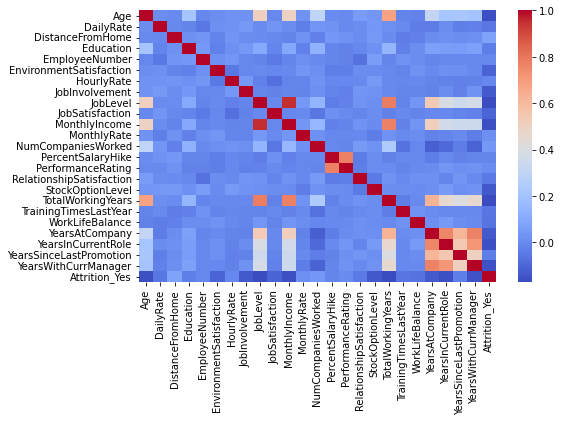

In [22]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')

In [23]:
# count the number of attrition entries
attrition_counts = train['Attrition_Yes'].value_counts()

# calculate the percentage out of total entries
attrition_percent = attrition_counts/attrition_counts.sum()

# make labels for plots
labels = ['Attrition_No-'+str((attrition_percent[0]*100).round(2))+'%', 'Attrition_Yes-'+str((attrition_percent[1]*100).round(2))+'%']

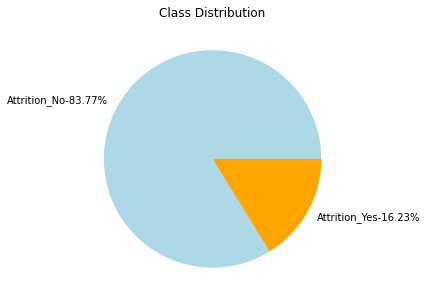

In [24]:
# check for class imbalance of the outcome variable
plt.pie(attrition_counts, labels=labels, colors=['lightblue', 'orange'])
plt.title('Class Distribution')
plt.show()

class imbalance in the outcome variable, maybe do resampling techniques: This involves either oversampling the minority class by duplicating existing examples or undersampling the majority class by reducing the number of examples. Common resampling techniques include random oversampling, random undersampling, and Synthetic Minority Over-sampling Technique (SMOTE). Do this before training the model

<AxesSubplot:xlabel='Attrition_Yes', ylabel='MonthlyIncome'>

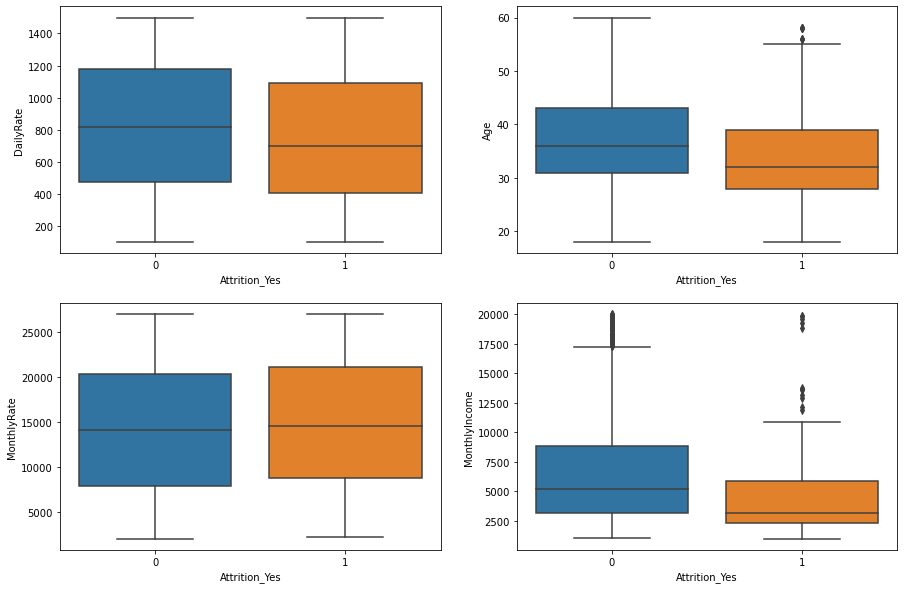

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
sns.boxplot(data=df, x='Attrition_Yes', y='DailyRate', ax=axes[0, 0])
sns.boxplot(data=df, x='Attrition_Yes', y='Age', ax=axes[0, 1])
sns.boxplot(data=df, x='Attrition_Yes', y='MonthlyRate', ax=axes[1, 0])
sns.boxplot(data=df, x='Attrition_Yes', y='MonthlyIncome', ax=axes[1, 1])

In machine learning, having a class imbalance problem can lead to biased models and poor predictive performance. If one class has significantly fewer examples than the other classes, the model may not learn enough from the minority class and may struggle to generalize well to new data.
In our case, having only 16% of Attrition = Yes suggests that our dataset has a significant class imbalance. This can lead to issues such as too many false negatives and reduced model performance overall.
To address this class imbalance problem, we chose to oversample the minority class, as shown in the code below.

In [26]:
# separate the target variable and predictor variables
X = df.drop(columns = ['Attrition_Yes'], axis=1)
y = df['Attrition_Yes']

In [27]:
X = X.rename(columns=lambda x: x.strip())

X = pd.get_dummies(X, drop_first = True)
X.columns = X.columns.str.replace('-', '')
X.columns = X.columns.str.replace(' ', '')
X.columns = X.columns.str.replace('&', '_')

X

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,1,2,94,3,2,4,...,0,0,0,0,0,1,0,0,1,1
1,49,279,8,1,2,3,61,2,2,2,...,0,0,0,0,1,0,0,1,0,0
2,37,1373,2,2,4,4,92,2,1,3,...,1,0,0,0,0,0,0,0,1,1
3,33,1392,3,4,5,4,56,3,1,3,...,0,0,0,0,1,0,0,1,0,1
4,27,591,2,1,7,1,40,3,1,2,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,2061,3,41,4,2,4,...,1,0,0,0,0,0,0,1,0,0
1466,39,613,6,1,2062,4,42,2,3,1,...,0,0,0,0,0,0,0,1,0,0
1467,27,155,4,3,2064,2,87,4,2,2,...,0,0,1,0,0,0,0,1,0,1
1468,49,1023,2,3,2065,4,63,2,2,2,...,0,0,0,0,0,1,0,1,0,0


In [28]:
test = test.rename(columns=lambda x: x.strip())

test = pd.get_dummies(test, drop_first = True)
test.columns = test.columns.str.replace('-', '')
test.columns = test.columns.str.replace(' ', '')
test.columns = test.columns.str.replace('&', '_')

test = pd.get_dummies(test, drop_first = True)
test.shape

(441, 46)

In [29]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# perform oversampling on the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# print the number of examples in each class before and after oversampling
print("Before oversampling:")
print(y_train.value_counts())
print("After oversampling:")
print(y_train_resampled.value_counts())

Before oversampling:
0    978
1    198
Name: Attrition_Yes, dtype: int64
After oversampling:
0    978
1    978
Name: Attrition_Yes, dtype: int64


In [30]:
y_train_resampled.name = 'Attrition_Yes'

# Checking VIF, dropping variables with VIF>10 1-by-1

In [31]:
# check for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  596.631312
1                                Age    2.193194
2                          DailyRate    1.079127
3                   DistanceFromHome    1.085088
4                          Education    1.131678
5                     EmployeeNumber    1.067639
6            EnvironmentSatisfaction    1.067232
7                         HourlyRate    1.053239
8                     JobInvolvement    1.065647
9                           JobLevel   15.426832
10                   JobSatisfaction    1.072875
11                     MonthlyIncome   18.192908
12                       MonthlyRate    1.096248
13                NumCompaniesWorked    1.339920
14                 PercentSalaryHike    2.590110
15                 PerformanceRating    2.566481
16          RelationshipSatisfaction    1.060952
17                  StockOptionLevel    1.984369
18                 TotalWorkingYears    5.441899
19             Train

In [32]:
# Drop the feature with the greatest VIF (Department_Reearch_Development)
col_to_drop = ["Department_Research_Development"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [33]:
#Retesting VIF without Department_Research_Development
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  354.460687
1                                Age    2.193194
2                          DailyRate    1.079122
3                   DistanceFromHome    1.083467
4                          Education    1.130747
5                     EmployeeNumber    1.067608
6            EnvironmentSatisfaction    1.066861
7                         HourlyRate    1.053187
8                     JobInvolvement    1.064846
9                           JobLevel   15.418660
10                   JobSatisfaction    1.072872
11                     MonthlyIncome   18.184693
12                       MonthlyRate    1.094678
13                NumCompaniesWorked    1.337916
14                 PercentSalaryHike    2.588563
15                 PerformanceRating    2.566358
16          RelationshipSatisfaction    1.059649
17                  StockOptionLevel    1.984009
18                 TotalWorkingYears    5.423582
19             Train

In [34]:
# Drop the feature with the greatest VIF (Department_Sales)
col_to_drop = ["Department_Sales"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [35]:
#Retesting VIF without Department_Sales
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  354.426165
1                                Age    2.192868
2                          DailyRate    1.078610
3                   DistanceFromHome    1.083052
4                          Education    1.130226
5                     EmployeeNumber    1.067222
6            EnvironmentSatisfaction    1.064463
7                         HourlyRate    1.053035
8                     JobInvolvement    1.061979
9                           JobLevel   15.413640
10                   JobSatisfaction    1.072613
11                     MonthlyIncome   18.153276
12                       MonthlyRate    1.094675
13                NumCompaniesWorked    1.337682
14                 PercentSalaryHike    2.580733
15                 PerformanceRating    2.563686
16          RelationshipSatisfaction    1.059632
17                  StockOptionLevel    1.983423
18                 TotalWorkingYears    5.423571
19             Train

In [36]:
# Drop the feature with the greatest VIF (EducationField_LifeSciences)
col_to_drop = ["EducationField_LifeSciences"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [37]:
#Retesting VIF without EducationField_LifeSciences
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  275.768048
1                                Age    2.192837
2                          DailyRate    1.077953
3                   DistanceFromHome    1.082457
4                          Education    1.128636
5                     EmployeeNumber    1.066762
6            EnvironmentSatisfaction    1.063689
7                         HourlyRate    1.051971
8                     JobInvolvement    1.061926
9                           JobLevel   15.412618
10                   JobSatisfaction    1.072306
11                     MonthlyIncome   18.152727
12                       MonthlyRate    1.092353
13                NumCompaniesWorked    1.335664
14                 PercentSalaryHike    2.580235
15                 PerformanceRating    2.563067
16          RelationshipSatisfaction    1.059580
17                  StockOptionLevel    1.982964
18                 TotalWorkingYears    5.421276
19             Train

In [38]:
# Drop the feature with the greatest VIF (MonthlyIncome)
col_to_drop = ["MonthlyIncome"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [39]:
#Retesting VIF without MonthlyIncome
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  275.492166
1                                Age    2.191315
2                          DailyRate    1.073006
3                   DistanceFromHome    1.080057
4                          Education    1.128636
5                     EmployeeNumber    1.065420
6            EnvironmentSatisfaction    1.060994
7                         HourlyRate    1.051374
8                     JobInvolvement    1.056253
9                           JobLevel    7.017367
10                   JobSatisfaction    1.069075
11                       MonthlyRate    1.092300
12                NumCompaniesWorked    1.334593
13                 PercentSalaryHike    2.578916
14                 PerformanceRating    2.559941
15          RelationshipSatisfaction    1.059004
16                  StockOptionLevel    1.982880
17                 TotalWorkingYears    5.337605
18             TrainingTimesLastYear    1.058063
19                  

In [40]:
train = pd.concat([X_train_resampled, pd.DataFrame(y_train_resampled)],axis =1)

In [41]:
test = pd.concat([X_test, pd.DataFrame(y_test)],axis =1)
test.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Attrition_Yes
1041,28,866,5,3,1469,4,84,3,2,1,...,0,0,0,0,1,0,0,1,0,0
184,53,1084,13,2,250,4,57,4,2,1,...,0,1,0,0,0,0,0,0,0,0
1222,24,240,22,1,1714,4,58,1,1,3,...,0,0,0,0,0,0,1,0,0,1
67,45,1339,7,3,86,2,59,3,3,1,...,0,0,0,1,0,0,0,0,0,0
220,36,1396,5,2,304,4,62,3,2,2,...,0,0,0,0,0,0,0,1,0,0


In [42]:
column_list = train.columns.to_list()[:-1] #not including Attrition
column_list

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'BusinessTravel_Travel_Frequently',
 'BusinessTravel_Travel_Rarely',
 'EducationField_Marketing',
 'EducationField_Medical',
 'EducationField_Other',
 'EducationField_TechnicalDegree',
 'Gender_Male',
 'JobRole_HumanResources',
 'JobRole_LaboratoryTechnician',
 'JobRole_Manager',
 'JobRole_ManufacturingDirector',
 'JobRole_ResearchDirector',
 'JobRole_ResearchScientist',
 'JobRole_SalesExecutive',
 'JobRole_SalesRepresentative',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'OverTime_Yes']

In [43]:
formula = 'Attrition_Yes~'+'+'.join(column_list)

In [44]:
#logistic regression with all predictors
logit_model = smf.logit(formula=formula, data=train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.429967
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1914
Method:                           MLE   Df Model:                           41
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3797
Time:                        00:30:57   Log-Likelihood:                -841.02
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                3.929e-189
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.9725      1.039      0.936      0.349      -1.063       3.008
Age                                 -0.0196      0.009     -2.075      0.038      -0.038      -0.001
DailyRate                           -0.0002      0.000     -1.381      0.167      -0.001    9.35e-05
DistanceFromHome                     0.0416      0.008      5.253      0.000       0.026       0.057
Education                            0.0385      0.062      0.622      0.534      -0.083       0.160
EmployeeNumber                   -1.943e-05      0.000     -0.182      0.856      -0.000       0.000
EnvironmentSatisfaction             -0.3797      0.060     -6.308      0.000      -0.498      -0.262
HourlyRate                           0.0017      0.003      0.529      0.597      -0.005       0.008
JobInvolvement                      -0.4697      0.091     -5.164      0.000      -0.648      -0.291
JobLevel                             0.2208      0.161      1.368      0.171      -0.096       0.537
JobSatisfaction                     -0.3430      0.059     -5.826      0.000      -0.458      -0.228
MonthlyRate                       1.637e-05   8.86e-06      1.847      0.065      -1e-06    3.37e-05
NumCompaniesWorked                   0.1910      0.028      6.922      0.000       0.137       0.245
PercentSalaryHike                   -0.0491      0.027     -1.815      0.069      -0.102       0.004
PerformanceRating                   -0.0986      0.280     -0.353      0.724      -0.647       0.450
RelationshipSatisfaction            -0.1318      0.057     -2.307      0.021      -0.244      -0.020
StockOptionLevel                    -0.1489      0.101     -1.471      0.141      -0.347       0.050
TotalWorkingYears                   -0.0855      0.020     -4.286      0.000      -0.125      -0.046
TrainingTimesLastYear               -0.1464      0.049     -2.979      0.003      -0.243      -0.050
WorkLifeBalance                     -0.4767      0.088     -5.420      0.000      -0.649      -0.304
YearsAtCompany                       0.1870      0.024      7.870      0.000       0.140       0.234
YearsInCurrentRole                  -0.1993      0.033     -6.121      0.000      -0.263      -0.135
YearsSinceLastPromotion              0.1320      0.028      4.738      0.000       0.077       0.187
YearsWithCurrManager                -0.1497      0.030     -4.993      0.000      -0.209      -0.091
BusinessTravel_Travel_Frequently     1.7815      0.282      6.308      0.000       1.228       2.335
BusinessTravel_Travel_Rarely         1.0784      0.257      4.190      0.000       0.574       1.583
EducationField_Marketing             0.1489      0.248      0.601      0.548      -0.337       0.634
EducationField_Medical               0.2453      0.149      1.643      0.100      -0.047       0.538
EducationField_Other                 0.6779      0.265      2.556      0.011       0.158       1.198
Education

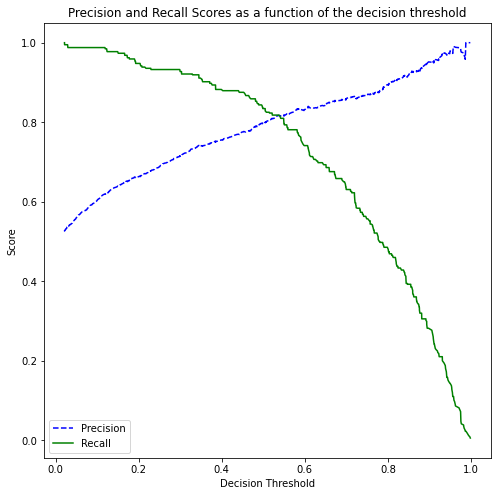

In [45]:
from sklearn.metrics import precision_recall_curve
y=train.Attrition_Yes
ypred = logit_model.predict(train)
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Classification accuracy = 81.1%
Precision = 79.8%
TPR or Recall = 83.4%
FNR = 16.6%
FPR = 21.2%
ROC-AUC = 88.3%


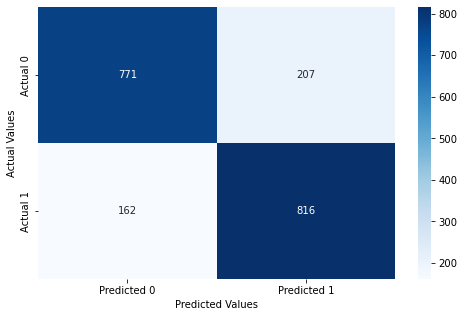

In [46]:
confusion_matrix_data(train,train.Attrition_Yes,logit_model,0.5)

Classification accuracy = 72.8%
Precision = 27.0%
TPR or Recall = 61.5%
FNR = 38.5%
FPR = 25.5%
ROC-AUC = 76.5%


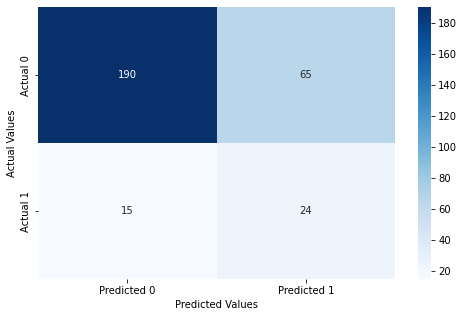

In [47]:
confusion_matrix_data(test,test.Attrition_Yes,logit_model,0.5)

In [48]:
#confusion_matrix_data(test,test.Attrition_Yes,best_fwd_reg_model,0.5)

0.8830027475629493


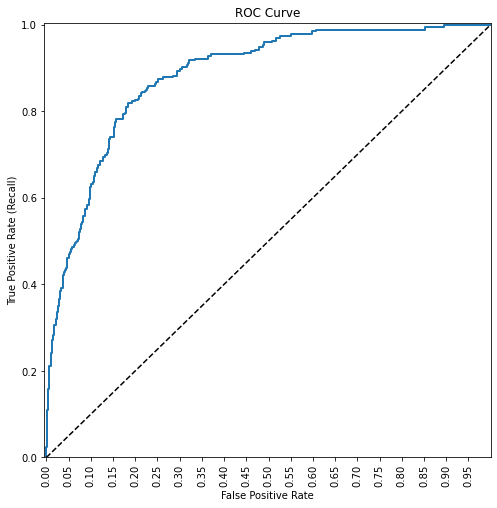

In [49]:
from sklearn.metrics import roc_curve, auc
y=train.Attrition_Yes
ypred = logit_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

maybe another model with interaction terms and other transformations

## doing transformations

In [50]:
warnings.filterwarnings('ignore')

In [51]:
train.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_TechnicalDegree', 'Gender_Male',
       'JobRole_HumanResources', 'JobRole_LaboratoryTechnician',
       'JobRole_Manager', 'JobRole_ManufacturingDirector',
       'JobRole_ResearchDirector', 'JobRole_ResearchScientist',
       'JobRole_SalesExecutive', 'JobRole_SalesRepresentative',
       'MaritalStatus_Married', 'Marita

In [52]:
column_list = list(train.columns)
unwanted = {'Attrition_Yes'}
predictors = [e for e in column_list if e not in unwanted]

formula = 'Attrition_Yes~'+'+'.join(predictors)

In [53]:
log_model = sm.logit(formula = formula, data = train).fit()

Optimization terminated successfully.
         Current function value: 0.429967
         Iterations 7


Text(0.5, 1.0, 'Attrition Percent based on Age')

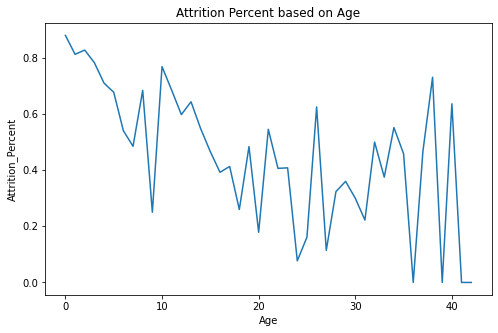

In [54]:
JobLevel_data = train.groupby('Age')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = JobLevel_data.index, y= JobLevel_data['Attrition_Percent'])
plt.xlabel('Age')
plt.title("Attrition Percent based on Age")

Text(0.5, 1.0, 'Attrition Percent based on DailyRate')

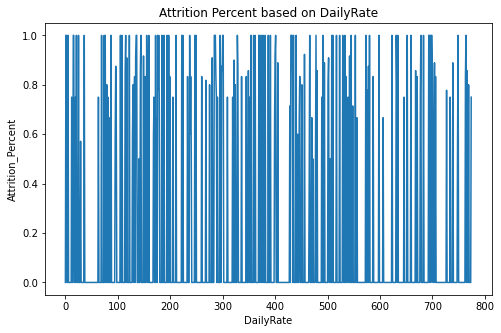

In [55]:
## should prob bin this
Stock_data = train.groupby('DailyRate')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('DailyRate')
plt.title("Attrition Percent based on DailyRate")

Might be time series

Text(0.5, 1.0, 'Attrition Percent based on DistanceFromHome')

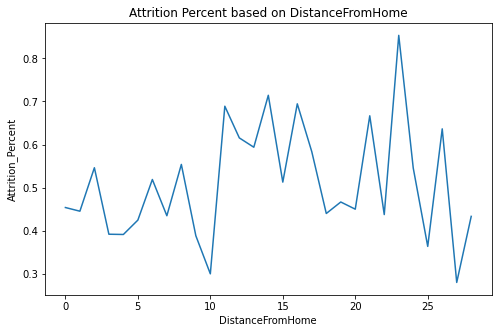

In [56]:
Stock_data = train.groupby('DistanceFromHome')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('DistanceFromHome')
plt.title("Attrition Percent based on DistanceFromHome")

Text(0.5, 1.0, 'Attrition Percent based on Education')

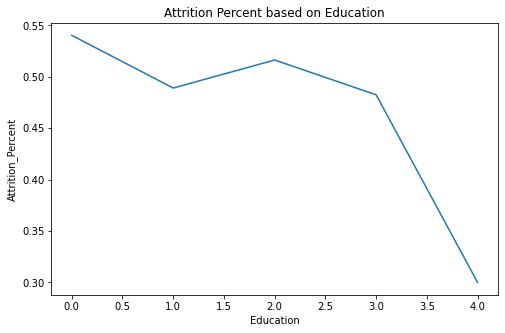

In [57]:
Stock_data = train.groupby('Education')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('Education')
plt.title("Attrition Percent based on Education")

In [58]:
log_model = sm.logit(formula = formula, data = train).fit()

Optimization terminated successfully.
         Current function value: 0.429967
         Iterations 7


Text(0.5, 1.0, 'Attrition Percent based on EmployeeNumber')

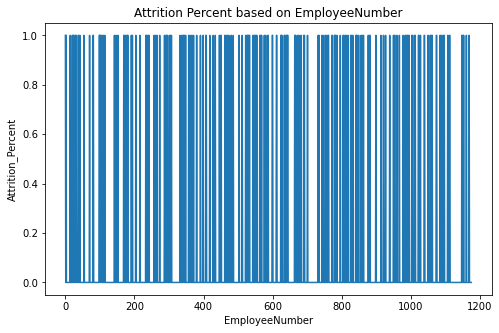

In [59]:
Stock_data = train.groupby('EmployeeNumber')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('EmployeeNumber')
plt.title("Attrition Percent based on EmployeeNumber")

Text(0.5, 1.0, 'Attrition Percent based on EnvironmentSatisfaction')

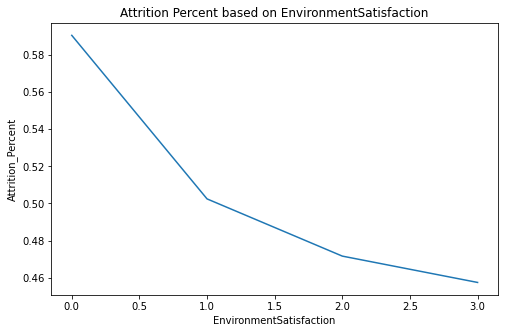

In [60]:
Stock_data = train.groupby('EnvironmentSatisfaction')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('EnvironmentSatisfaction')
plt.title("Attrition Percent based on EnvironmentSatisfaction")

Text(0.5, 1.0, 'Attrition Percent based on HourlyRate')

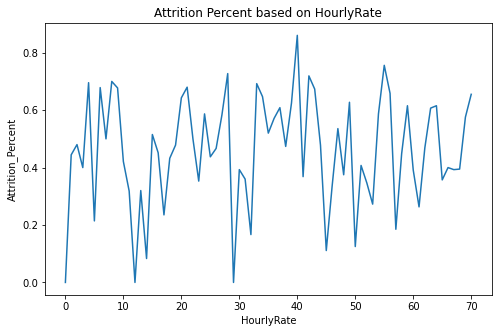

In [61]:
Stock_data = train.groupby('HourlyRate')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('HourlyRate')
plt.title("Attrition Percent based on HourlyRate")

Text(0.5, 1.0, 'Attrition Percent based on JobInvolvement')

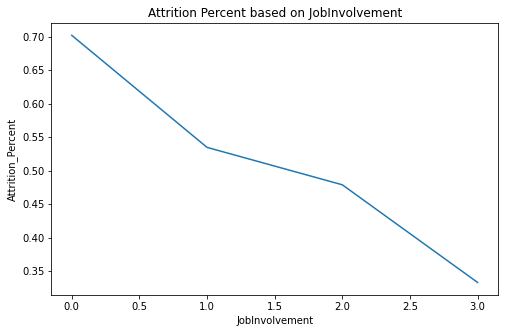

In [62]:
Stock_data = train.groupby('JobInvolvement')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('JobInvolvement')
plt.title("Attrition Percent based on JobInvolvement")

Text(0.5, 1.0, 'Attrition Percent based on JobLevel')

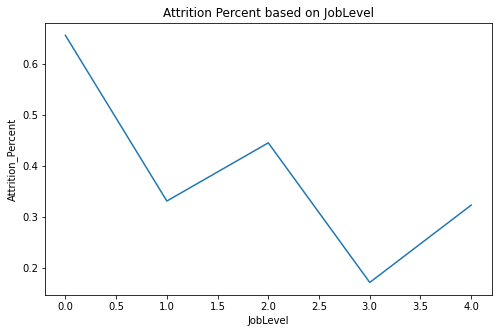

In [63]:
Stock_data = train.groupby('JobLevel')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('JobLevel')
plt.title("Attrition Percent based on JobLevel")

Text(0.5, 1.0, 'Attrition Percent based on JobSatisfaction')

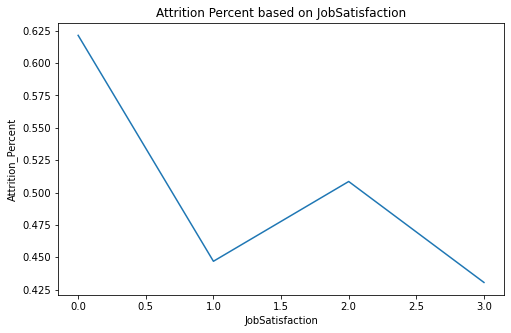

In [64]:
Stock_data = train.groupby('JobSatisfaction')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('JobSatisfaction')
plt.title("Attrition Percent based on JobSatisfaction")

Text(0.5, 1.0, 'Attrition Percent based on MonthlyRate')

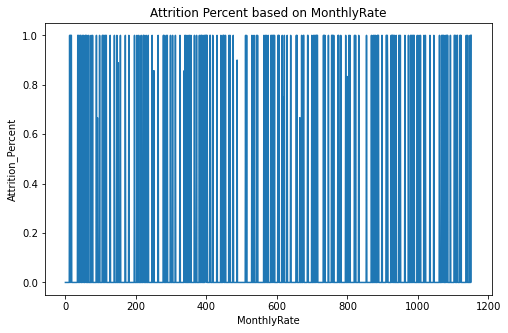

In [65]:
Stock_data = train.groupby('MonthlyRate')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('MonthlyRate')
plt.title("Attrition Percent based on MonthlyRate")

Text(0.5, 1.0, 'Attrition Percent based on NumCompaniesWorked')

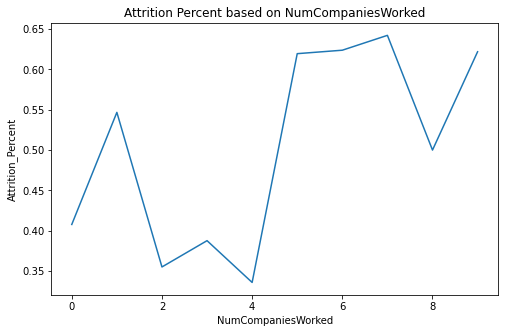

In [66]:
Stock_data = train.groupby('NumCompaniesWorked')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('NumCompaniesWorked')
plt.title("Attrition Percent based on NumCompaniesWorked")

Text(0.5, 1.0, 'Attrition Percent based on PercentSalaryHike')

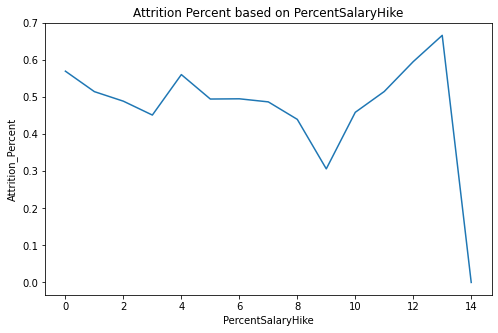

In [67]:
Stock_data = train.groupby('PercentSalaryHike')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('PercentSalaryHike')
plt.title("Attrition Percent based on PercentSalaryHike")

Text(0.5, 1.0, 'Attrition Percent based on PerformanceRating')

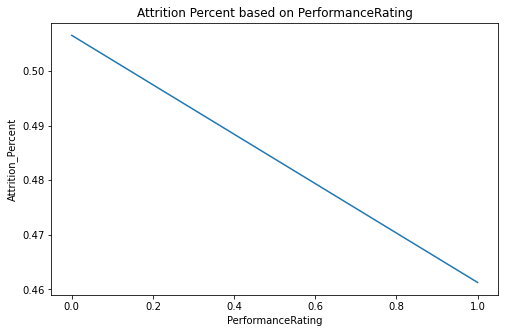

In [68]:
Stock_data = train.groupby('PerformanceRating')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('PerformanceRating')
plt.title("Attrition Percent based on PerformanceRating")

Text(0.5, 1.0, 'Attrition Percent based on RelationshipSatisfaction')

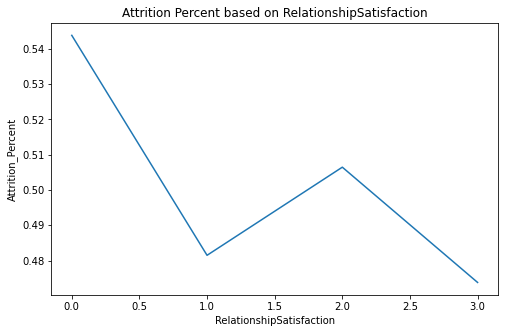

In [69]:
Stock_data = train.groupby('RelationshipSatisfaction')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('RelationshipSatisfaction')
plt.title("Attrition Percent based on RelationshipSatisfaction")

Text(0.5, 1.0, 'Attrition Percent based on StockOptionLevel')

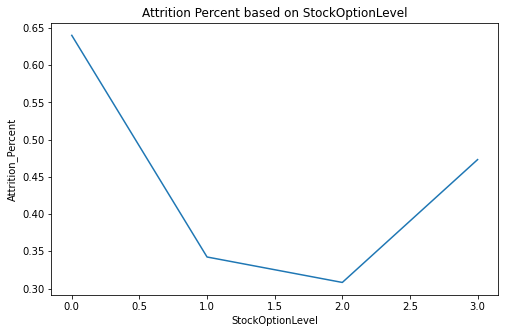

In [70]:
Stock_data = train.groupby('StockOptionLevel')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('StockOptionLevel')
plt.title("Attrition Percent based on StockOptionLevel")

Text(0.5, 1.0, 'Attrition Percent based on TotalWorkingYears')

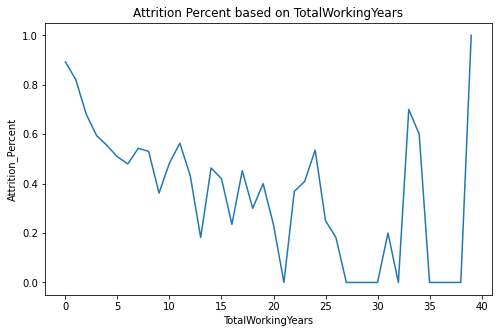

In [71]:
Stock_data = train.groupby('TotalWorkingYears')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('TotalWorkingYears')
plt.title("Attrition Percent based on TotalWorkingYears")

Text(0.5, 1.0, 'Attrition Percent based on TrainingTimesLastYear')

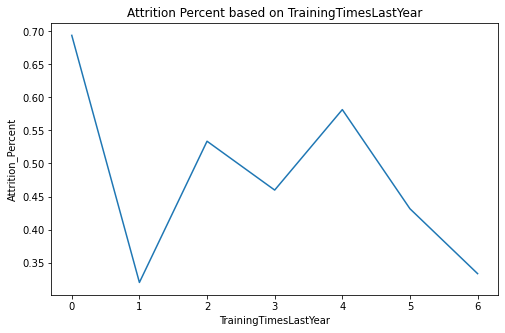

In [72]:
Stock_data = train.groupby('TrainingTimesLastYear')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('TrainingTimesLastYear')
plt.title("Attrition Percent based on TrainingTimesLastYear")

Text(0.5, 1.0, 'Attrition Percent based on PerformanceRating')

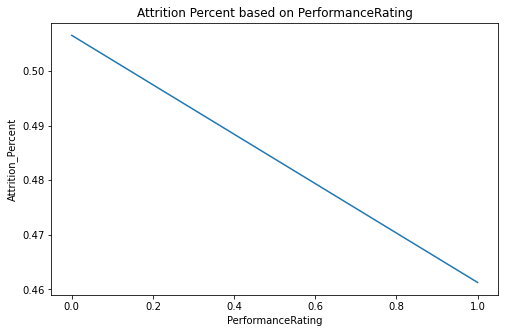

In [73]:
Stock_data = train.groupby('PerformanceRating')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('PerformanceRating')
plt.title("Attrition Percent based on PerformanceRating")

Text(0.5, 1.0, 'Attrition Percent based on RelationshipSatisfaction')

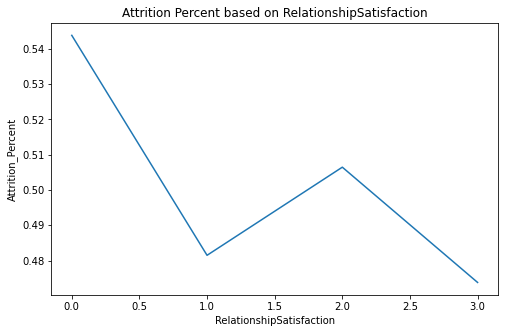

In [74]:
Stock_data = train.groupby('RelationshipSatisfaction')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('RelationshipSatisfaction')
plt.title("Attrition Percent based on RelationshipSatisfaction")

Text(0.5, 1.0, 'Attrition Percent based on StockOptionLevel')

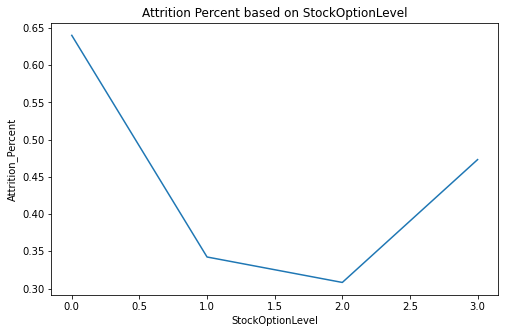

In [75]:
Stock_data = train.groupby('StockOptionLevel')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('StockOptionLevel')
plt.title("Attrition Percent based on StockOptionLevel")

Text(0.5, 1.0, 'Attrition Percent based on TotalWorkingYears')

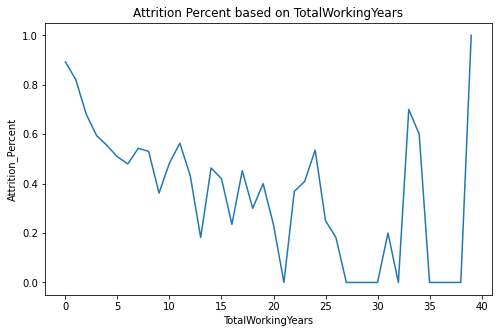

In [76]:
Stock_data = train.groupby('TotalWorkingYears')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('TotalWorkingYears')
plt.title("Attrition Percent based on TotalWorkingYears")

Text(0.5, 1.0, 'Attrition Percent based on TrainingTimesLastYear')

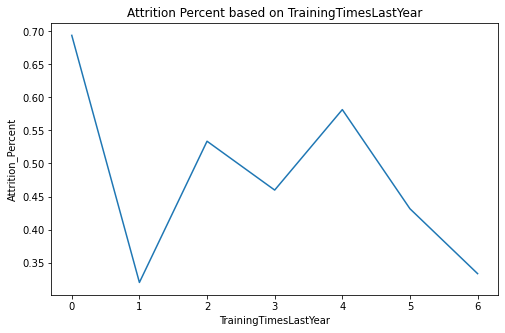

In [77]:
Stock_data = train.groupby('TrainingTimesLastYear')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('TrainingTimesLastYear')
plt.title("Attrition Percent based on TrainingTimesLastYear")

Text(0.5, 1.0, 'Attrition Percent based on WorkLifeBalance')

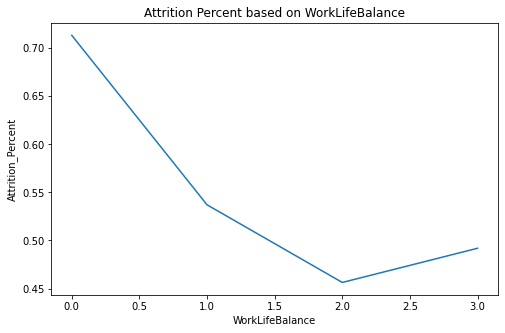

In [78]:
Stock_data = train.groupby('WorkLifeBalance')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('WorkLifeBalance')
plt.title("Attrition Percent based on WorkLifeBalance")

Text(0.5, 1.0, 'Attrition Percent based on YearsAtCompany')

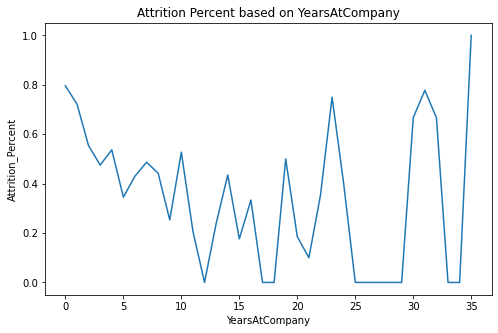

In [79]:
Stock_data = train.groupby('YearsAtCompany')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('YearsAtCompany')
plt.title("Attrition Percent based on YearsAtCompany")

Text(0.5, 1.0, 'Attrition Percent based on YearsInCurrentRole')

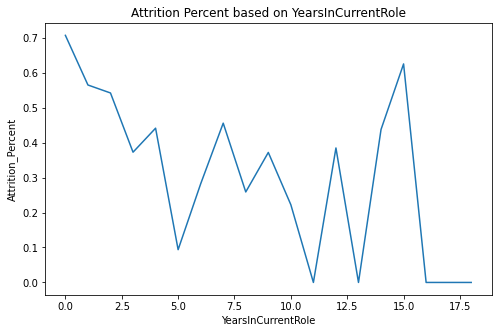

In [80]:
Stock_data = train.groupby('YearsInCurrentRole')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('YearsInCurrentRole')
plt.title("Attrition Percent based on YearsInCurrentRole")

Text(0.5, 1.0, 'Attrition Percent based on YearsSinceLastPromotion')

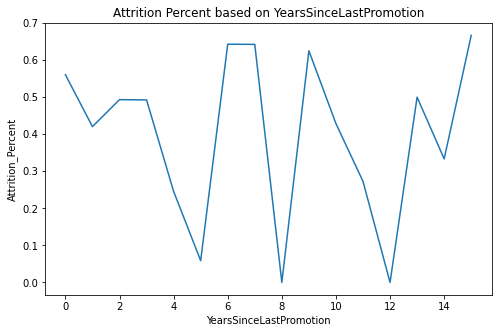

In [81]:
Stock_data = train.groupby('YearsSinceLastPromotion')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('YearsSinceLastPromotion')
plt.title("Attrition Percent based on YearsSinceLastPromotion")

Text(0.5, 1.0, 'Attrition Percent based on YearsWithCurrManager')

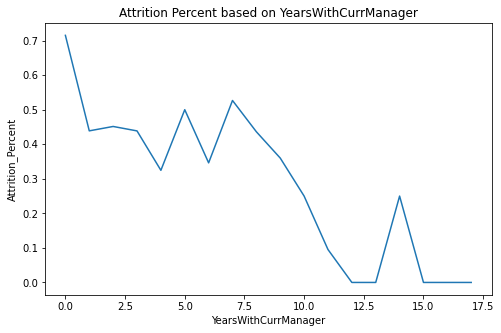

In [82]:
Stock_data = train.groupby('YearsWithCurrManager')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('YearsWithCurrManager')
plt.title("Attrition Percent based on YearsWithCurrManager")

In [83]:
column_list = list(train.columns)
unwanted = {'Attrition_Yes'}
predictors = [e for e in column_list if e not in unwanted]

formula = 'Attrition_Yes~'+'+'.join(predictors)

In [84]:
log_model = sm.logit(formula = formula, data = train).fit()

Optimization terminated successfully.
         Current function value: 0.429967
         Iterations 7


In [85]:
# Made DistanceFromHome quadratic
log_model = sm.logit('Attrition_Yes ~ YearsAtCompany**2+' + '+'.join(predictors), data = train).fit()

Optimization terminated successfully.
         Current function value: 0.429967
         Iterations 7


In [88]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)
# class_acc(data = test, actual_values = test.Attrition_Yes, model = log_model)

Optimization terminated successfully.
         Current function value: 0.441867
         Iterations 7
TPR or Recall = 82.7%


In [89]:
# Made DistanceFromHome quadratic
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

Optimization terminated successfully.
         Current function value: 0.438854
         Iterations 7
TPR or Recall = 83.3%


In [87]:
def recall(data, actual_values, model, cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    print("TPR or Recall = {:.1%}".format(tpr))

In [90]:
## brute force interaction terms 
## goal is to maximize recall

log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

Optimization terminated successfully.
         Current function value: 0.441867
         Iterations 7
TPR or Recall = 82.7%


In [91]:
#Binning TrainingTimesLastYear
def var_transform(data, train_values, data_values):
    binned = pd.qcut(train_values,10,retbins=True, duplicates = 'drop')
    bins = binned[1]
    data['binned'] = pd.cut(data_values,bins = bins)
    dum = pd.get_dummies(data.binned,drop_first = True)
    dum.columns = ['name'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

## Below here is forward selection

In [ ]:
#Function to develop a model based on all predictors in predictor_subset
# X = train.drop(["Attrition_Yes",'JobRole','OverTime'], axis = 1)
## X = X.rename(columns=lambda x: x.strip())
## X['JobRole'] = X['JobRole'].astype(str)

train = train.apply(lambda x: x.str.strip() if isinstance(x.iloc[0], str) else x)
def processSubset(predictor_subset):
    if 'Attrition_Yes' in predictor_subset:
        predictor_subset = predictor_subset.remove('Attrition_Yes')

    # Fit model on feature_set and calculate R-squared
    #model = sm.ols('Attrition_Yes~' + '+'.join(predictor_subset),data = train_num).fit()
    #Developing logistic regression model
    logit_model = sm.logit(formula = 'Attrition_Yes~' + '+'.join(predictor_subset),data = train).fit() 
    llf = logit_model.llf
    return {"logit_model":logit_model, "Log-Likelihood":llf}

In [ ]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
import time
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train_resampled.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Log-Likelihood'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Log-Likelihood", "logit_model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X_train_resampled.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["logit_model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

#make dummies for all categorical variables
#change R-squared to log likelihood, keep AIC and BIC
#show all three graphs in
#check for multi-collinearity among all variables first, remove the ones that are colinear (decide which one is most important), then do forward stepwise - use VIF score, (email Krish about what threshold to use, 5 and below you should be good) if they're above the threshold point, remove them
#change predictors to be dummies rather than just dummy variables because forward selection might decide that one of them isn't important and not include them - less of a priority, but if we have time

In [ ]:
models_best = forward_selection()

In [ ]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Log-Likelihood"])
    plt.xlabel('# Predictors')
    plt.ylabel('Log-Likelihood')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    """
    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('psuedo rsquared')
    """

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [ ]:
best_fwd_reg_model = models_best['logit_model'][25]
best_fwd_reg_model.summary()

In [ ]:
confusion_matrix_data(train,train.Attrition_Yes,best_fwd_reg_model,0.5)

In [ ]:
# confusion_matrix_test(test,test.Attrition_Yes,best_fwd_reg_model,0.55)

In [ ]:
from sklearn.metrics import roc_curve, auc
y=train.Attrition_Yes
ypred = best_fwd_reg_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

# Adding interactions and transformations

In [ ]:
def recall(data, actual_values, model, cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    print("TPR or Recall = {:.1%}".format(tpr))

In [ ]:
## brute force interaction terms
## goal is to maximize recall

log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)
# class_acc(data = test, actual_values = test.Attrition_Yes, model = log_model)

In [ ]:
# Made DistanceFromHome quadratic
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
# made TrainingTimesLastYear quadratic
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + (DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
confusion_matrix_data(train, train.Attrition_Yes,log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree+ JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree + JobInvolvement + JobRole_ResearchScientist*YearsWithCurrManager + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree + JobInvolvement + JobRole_ResearchScientist*YearsWithCurrManager + JobRole_ResearchScientist*NumCompaniesWorked + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree + JobInvolvement + JobRole_ResearchScientist*YearsWithCurrManager + JobRole_ResearchScientist*NumCompaniesWorked + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction*JobRole_HumanResources + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree + JobInvolvement + JobRole_ResearchScientist*YearsWithCurrManager + JobRole_ResearchScientist*NumCompaniesWorked + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction*JobRole_HumanResources + BusinessTravel_Travel_Frequently*DistanceFromHome + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree + JobInvolvement + JobRole_ResearchScientist*YearsWithCurrManager + JobRole_ResearchScientist*NumCompaniesWorked + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction*JobRole_HumanResources + BusinessTravel_Travel_Frequently*DistanceFromHome + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome*JobRole_SalesExecutive + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree + JobInvolvement + JobRole_ResearchScientist*YearsWithCurrManager + JobRole_ResearchScientist*NumCompaniesWorked + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction*JobRole_HumanResources + BusinessTravel_Travel_Frequently*DistanceFromHome + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome*JobRole_SalesExecutive + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)
log_model.summary()

In [ ]:
confusion_matrix_data(train,train.Attrition_Yes,log_model)

In [ ]:
from sklearn.metrics import roc_curve, auc
y=train.Attrition_Yes
ypred = log_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

In [ ]:
test.shape
70/371
100-18.8

In [ ]:
confusion_matrix_data(test, test.Attrition_Yes, log_model)

In [ ]:
from sklearn.metrics import roc_curve, auc
y=test.Attrition_Yes
ypred = log_model.predict(test)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

## The code below this is useless

In [ ]:
#Binning YearsAtCompany
def var_transform(data, train_values, data_values):
    binned = pd.qcut(train_values,10,retbins=True, duplicates = 'drop')
    bins = binned[1]
    data['binned'] = pd.cut(data_values,bins = bins)
    dum = pd.get_dummies(data.binned,drop_first = True)
    dum.columns = ['name'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [ ]:
train = var_transform(train, train.YearsAtCompany, train.YearsAtCompany)

data = train.groupby('binned')['Attrition_Yes'].agg([('percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = data.index, y= data['percent'])
plt.xlabel('bin')

In [ ]:
sns.lineplot(x = age_data.index, y= age_data['attrition_percent'])
plt.xlabel('Age_bin')


In [ ]:
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(train.Age,0), y = jitter(train.attrition_percent,0), data = train, color = 'orange')
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
logit_model = sm.logit(formula = 'Outcome~Age+I(Age**2)', data = train).fit()
sns.lineplot(x = 'Age', y= logit_model.predict(train), data = train, color = 'blue') 
logit_model.llf

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
class_acc(data = train, actual_values = train.Attrition_Yes, model = log_model)


In [ ]:
#interactions: consider all possible - do what we did in Assignment E, include all 2 interactions with stepwise
#might consider 3-factor interactions
#don't do interactions for variables that are the same level

# Ways we improved the model with all predictors
- checked for correlated variables (VIF >10), dropped the correlated variables 1-by-1 until there was no correlation >10

Ways we improved the model after forward selection
Found collinear predictors (JobLevel and TotalWorkingYears) and found that including TotalWorkingYears made a better model because it had a higher Log-Likelihood, Classification Accuracy, Precision, and Recall

# Final Model ATM: logit_model_TotalWorkingYears

In [ ]:
# #Model with all predictors
# logit_model_all = sm.logit(formula = 'Attrition_Yes ~ OverTime + JobLevel + StockOptionLevel + JobInvolvement + BusinessTravel + NumCompaniesWorked + JobSatisfaction + EnvironmentSatisfaction + EducationField + WorkLifeBalance + Age + DistanceFromHome + YearsSinceLastPromotion + YearsInCurrentRole + YearsAtCompany + TotalWorkingYears + YearsWithCurrManager + Gender + PercentSalaryHike', data = train).fit() #Developing logistic regression model
# logit_model_all.summary()

In [ ]:
# #Model with JobLevel
# logit_model_JobLevel = sm.logit(formula = 'Attrition_Yes ~ OverTime + JobLevel + StockOptionLevel + JobInvolvement + BusinessTravel + NumCompaniesWorked + JobSatisfaction + EnvironmentSatisfaction + EducationField + WorkLifeBalance + Age + DistanceFromHome + YearsSinceLastPromotion + YearsInCurrentRole + YearsAtCompany + YearsWithCurrManager + Gender + PercentSalaryHike', data = train).fit() #Developing logistic regression model
# logit_model_JobLevel.summary()

In [ ]:
# #Model with TotalWorkingYears
# logit_model_TotalWorkingYears = sm.logit(formula = 'Attrition_Yes ~ OverTime + StockOptionLevel + JobInvolvement + BusinessTravel + NumCompaniesWorked + JobSatisfaction + EnvironmentSatisfaction + EducationField + WorkLifeBalance + Age + DistanceFromHome + YearsSinceLastPromotion + YearsInCurrentRole + YearsAtCompany + TotalWorkingYears + YearsWithCurrManager + Gender + PercentSalaryHike', data = train).fit() #Developing logistic regression model
# logit_model_TotalWorkingYears.summary()

In [ ]:
# confusion_matrix_data(train,train.Attrition_Yes,logit_model_TotalWorkingYears,0.4)

In [ ]:
# confusion_matrix_data(test,test.Attrition_Yes,logit_model_TotalWorkingYears,0.4)

In [ ]:
#Model with Interactions
#logit_model_interaction1 = sm.logit(formula = 'Attrition_Yes ~ OverTime + StockOptionLevel*JobLevel + JobInvolvement*BusinessTravel + NumCompaniesWorked*Age + JobSatisfaction + EnvironmentSatisfaction + EducationField + WorkLifeBalance + Age*JobLevel + Age*TotalWorkingYears + DistanceFromHome + YearsSinceLastPromotion + YearsInCurrentRole + YearsAtCompany + TotalWorkingYears + YearsWithCurrManager + Gender + PercentSalaryHike', data = train).fit() #Developing logistic regression model

In [ ]:
#confusion_matrix_data(test,test.Attrition_Yes,logit_model_interaction1,0.4)